## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

b_modes = 3
t_modes = 3
fwt_modes = 1
# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes + fwt_modes)

## Create some global parameters
p.c = mf.ModelSymbol(value = 1.8,string = 'c') # chord of wing
p.s_t = mf.ModelSymbol(value = 12,string = 's_t') # total semi-span of wing
p.rho_t = mf.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)
p.ratio_fwt = mf.ModelSymbol(value = 0.2,string = 'sigma') # percentage of wing that is a FWT


# Respective spans
p.s_0 =  p.s_t*(1-p.ratio_fwt) # span of inner wing
p.s_1 =  p.s_t*p.ratio_fwt # span of inner wing

# Inner Wing stiffness Properties
p.EI = mf.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = mf.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e_0 = mf.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c
p.e_1 = mf.ModelSymbol(value = 0,string = 'e_1') # e for the FWT
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c

# FWT Properties
p.m_1 = p.s_1*p.c*p.rho_t # mf.ModelSymbol(value = 0.3,string = 'm_1')
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)
p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle
p.Delta_m = mf.ModelSymbol(value = 0,string = 'Delta_m') # additional mass to apply at the FWT CoM

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord
p.y_1 = sym.Symbol('y_1') # FWT y chord
p.x_1 = sym.Symbol('x_1') # FWT x chord

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = mf.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term 

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')               # C_L slope of main wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1                                    # C_L slope of FWT
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

# Factor to change the size of joint values
p.eta = mf.ModelMatrix(value = [1]*(b_modes+t_modes+fwt_modes),symbols=sym.symbols(f'eta:{p.qs}'))

In [3]:
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})

fwt_root_frame = wing_frame.subs({p.y_0:p.s_0,p.x_0:p.x_f0}).Translate(-p.x_f0,0,0).R_x(-p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(p.x_f1,p.y_1,0)
fwt_com_frame = fwt_root_frame.Translate(p.c/2,p.s_1/2,0)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)
M_fwt = ele.MassMatrix(p.m_1-p.Delta_m,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

In [4]:
# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_flexural_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)

In [5]:
tau_s0 = tau_0 if isinstance(tau_0,int) else tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0 if isinstance(tau_0,int) else tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1

## Classic Way

In [16]:
%%time
fwt_AeroForces = ef.AeroForce.Generate(p,fwt_flexural_frame,p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

CPU times: user 23.8 s, sys: 49.8 ms, total: 23.9 s
Wall time: 23.9 s


In [7]:
y0 = [0]*p.qs*2
%timeit -n 100 fwt_AeroForces(p.GetNumericTuple(y0,0),y0,0)

155 µs ± 9.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Create Transforms

In [17]:
%%time
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

CPU times: user 1min 4s, sys: 313 ms, total: 1min 4s
Wall time: 1min 4s


In [18]:
y0 = [0]*p.qs*2
tup = p.GetNumericTuple(y0,0)
%timeit -n 100 sm.deriv(0,y0,tup)
%timeit -n 100 sm.ExtForces(tup,y0,0)
%timeit -n 100 sm.M_func(tup,y0)
%timeit -n 100 sm.f_func(tup,y0)


348 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
150 µs ± 4.86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
49.8 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
57.7 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
y0 = [0]*p.qs*2
sm_test = sm.subs(p,p.GetSubs(0,[0]*p.qs*2))
tup = p.GetNumericTuple(y0,0)

fwt_AeroForces = ef.AeroForce(p,sym.trigsimp(sym.powsimp(sym.cancel(sym.expand(fwt_AeroForces._Q)))),fwt_AeroForces.dAlpha) 
%timeit -n 100 sm_test.deriv(0,y0,tup)
%timeit -n 100 sm_test.ExtForces(tup,y0,0)
%timeit -n 100 sm_test.M_func(tup,y0)
%timeit -n 100 sm_test.f_func(tup,y0)


78.3 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.58 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.21 µs ± 960 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


## create masses 

In [42]:
%%time
ignores = [p.V,p.ratio_fwt,p.Lambda,p.alpha_r,p.eta]

# sub in functions!
sm_mini = sm.subs(p,p.GetSubs(0,[0]*p.qs*2,ignore = ignores))

#linearise the Eom
sm_lin = sm_mini.linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)
func = sym.lambdify((ignores + [p.fp]),(K,M),'numpy')

AttributeError: 'int' object has no attribute 'subs'

In [6]:
q = sym.Matrix(p.fp[::2])
qd = sym.Matrix(p.fp[1::2])
f = (sm_lin.f-sm_lin.ExtForces.Q())
f = (sm_lin.f-sm_lin.ExtForces.Q()).subs({p.x[i]:p.fp[i] for i in range(-1,-len(p.x)-1,-1)}).subs({i:0 for i in qd})

In [7]:
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(10)
p.ratio_fwt.value = 0.2

values = [i.value for i in ignores]
func_obj = sym.lambdify((q,p.V),(f.T*f).subs(p.GetSubs(0,q,ignore=[p.fp,p.V]))[0])

In [11]:
df = pd.DataFrame(columns=['v','aoa','q','Lambda'])
vs = np.linspace(0,80,161)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    pLast = minimize(func_obj,pLast,method='CG',args=(v)).x
    v0 = [0]*p.qs
    y0 = [j for i in range(len(pLast)) for j in [pLast[i],v0[i]]]
    df = df.append({'aoa' : np.rad2deg(p.alpha_r.value), 'v' : v,'q':y0,'Lambda':np.rad2deg(p.Lambda.value)} , ignore_index=True)

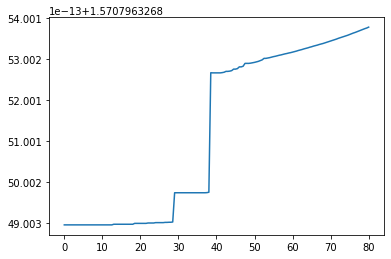

In [12]:
aoa = []
for i in df['q']:
    aoa.append(i[-2])
plt.plot(df['v'],aoa)

In [18]:
y0 = [0,0,0,0,0,0,0,0,np.pi/2]
func_obj(y0,0)

In [39]:
#create much artifical damping
def ArtDamping(tup,x,t):
    val = np.zeros((p.qs*2,1))
    val[::2] = -10*x[1::2]
    return val

ArtDampingForce = ef.CustomForce(p,ArtDamping)
sm_lin.ExtForces.forces.append(ArtDampingForce)

p.alpha_1._GetValue = types.MethodType(lambda self,t,x : 0 , p.alpha_1)
p.alphadot_1._GetValue = types.MethodType(lambda self,t,x : 0 , p.alphadot_1)

In [40]:
yData = solve_ivp(lambda t,y:sm.deriv(t,y,p.GetNumericTuple(y,t)),(0,5),[0]*p.qs*2)

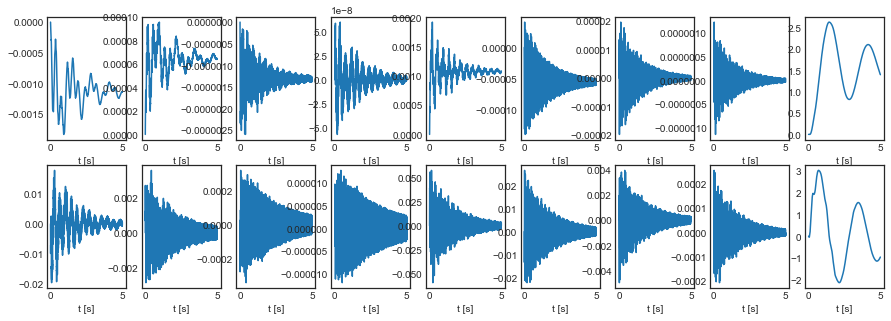

In [41]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

In [ ]:
flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    p.V.value = data['v'].iloc[i]
    q = data['q'].iloc[i]
    q=[0]*p.qs*2
    values = tuple([i.value for i in ignores])
    evals, evecs = eig(*func(*values,q))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(q)
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    jac_dat['Lambda'] = data['Lambda'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True) 

In [ ]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
#data = flutdfv2[flutdfv2['Stable']]
data = flutdfv2
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',ax=axes[2])

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,50))

In [ ]:
flutdfv2[flutdfv2['Stable']]['V'].max()

In [11]:
sym.Symbol('Delta_m')